<a href="https://colab.research.google.com/github/LihiShalmon/msc_academic_projects/blob/main/PS3_Attention_Please_2024_ID_208747287.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208747287
~~~

~~~
STUDENT GIT LINK: MISSING
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [ ]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).
a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

Simple arithmetic operations (e.g., addition, subtraction) are deterministic and rule-based. They don’t require the complex temporal modeling such as LSTMS which are designed for tasks involving sequential data with dependencies over time.
additinaly its error rate is high

b- The model assumes a fixed output length (config["digits"] + 1), which is not suitable for tasks where the output length varies (e.g., multiplication or division).




1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import wandb
from torch.utils.data import DataLoader, TensorDataset

# Initialize wandb
wandb.init()
config = wandb.config
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

wandb: Currently logged in as: lihi-shalmon-huji (lihi-shalmon-huji-hebrew-university-of-jerusalem). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


SOLUTION:

In [ ]:
! pip install wandb

### TensorFlow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import wandb

# Initialize wandb
wandb.init(project="seq2seq-arithmetic", config=config)
print(f"wandb run URL: {wandb.run.get_url()}")
config = wandb.config

config={
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 12,
    "chars": '0123456789-+ '
}
# Maximum length of input and output sequences
maxlen = config["digits"] + 1 + config["digits"]
output_sequence_length = config["digits"] + 1

# Character table for encoding/decoding
class CharacterTable:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = {c: i for i, c in enumerate(self.chars)}
        self.indices_char = {i: c for i, c in enumerate(self.chars)}

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)), dtype=np.float32)
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[i] for i in x)

ctable = CharacterTable(chars)

# Generate data
def generate_data():
    questions = []
    expected = []
    seen = set()
    print('Generating data...')
    while len(questions) < config["training_size"]:
        # All the numbers, plus sign and space for padding.
        chars = '0123456789+- '

        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        q = '{}-{}'.format(a, b)
        query = q + ' ' * (maxlen - len(q))
        ans = str(a - b)
        ans += ' ' * (output_sequence_length - len(ans))
        questions.append(query)
        expected.append(ans)
    print('Total questions:', len(questions))
    return questions, expected


questions, expected = generate_data()

wandb run URL: https://wandb.ai/lihi-shalmon-huji-hebrew-university-of-jerusalem/uncategorized/runs/7wwqxw4i
Generating data...
Total questions: 40000


In [ ]:
questions[:30]

['732-64   ',
 '1-0      ',
 '36-1770  ',
 '9-4197   ',
 '3-20     ',
 '2-93     ',
 '5608-578 ',
 '9679-133 ',
 '6046-5905',
 '782-4019 ',
 '662-750  ',
 '11-804   ',
 '9-357    ',
 '3-7      ',
 '295-398  ',
 '298-78   ',
 '2-86     ',
 '2-36     ',
 '1-88     ',
 '68-8344  ',
 '460-5    ',
 '6-875    ',
 '3-70     ',
 '5885-86  ',
 '65-394   ',
 '145-107  ',
 '15-2     ',
 '85-7     ',
 '94-368   ',
 '84-0     ']

In [ ]:
# Vectorization
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.float32)
y = np.zeros((len(questions), output_sequence_length, len(chars)), dtype=np.float32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, output_sequence_length)

# Shuffle data
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split data into training and validation sets
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]
print(f"x shape: {x.shape}")  # Should be (40000, 9, 13)
print(f"y shape: {y.shape}")  # Should be (40000, 5, 13)

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)

# Create DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

# Define the corrected model
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_len):
        super(Seq2SeqModel, self).__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.lstm1(x)

        # Expand the encoder's hidden state for the decoder
        hidden = hidden[-1]  # Shape: (batch_size, hidden_size)
        hidden = hidden.unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)
        hidden = hidden.repeat(1, self.max_len, 1)  # Shape: (batch_size, max_len, hidden_size)
        # Decoder
        output, _ = self.lstm2(hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqModel(
    input_size=len(chars),
    hidden_size=config["hidden_size"],
    output_size=len(chars),
    max_len=output_sequence_length  # Sequence length = 5
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for iteration in range(1, 10):
    print('-' * 50)
    print('Iteration', iteration)

    # Training
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        wandb.log({"loss": loss.item()})

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=2)
            targets = batch_y.argmax(dim=2)
            correct += (preds == targets).sum().item()
            total += batch_y.size(0) * batch_y.size(1)

    accuracy = correct / total
    print(f"Logging accuracy: {accuracy}")  # Debugging
    wandb.log({"accuracy": accuracy})
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Visualize errors
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[ind].unsqueeze(0).to(device), y_val[ind].unsqueeze(0).to(device)
        preds = model(rowx).argmax(dim=2)
        q = ctable.decode(rowx[0].cpu().numpy())
        correct = ctable.decode(rowy[0].cpu().numpy())
        guess = ctable.decode(preds[0].cpu().numpy(), calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('v', end=' ')
        else:
            print('x', end=' ')
        print(guess)

x shape: (40000, 9, 13)
y shape: (40000, 5, 13)
--------------------------------------------------
Iteration 1
Logging accuracy: 0.3544
Validation Accuracy: 0.3544
Q 362-656   T -294  ☒ -22  
Q 312-7530  T -7218 ☒ -22  
Q 204-6     T 198   ☒ -21  
Q 789-1633  T -844  ☒ -22  
Q 52-210    T -158  ☒ -21  
Q 7468-65   T 7403  ☒ -22  
Q 3289-72   T 3217  ☒ -22  
Q 532-997   T -465  ☒ -22  
Q 6004-2716 T 3288  ☒ -22  
Q 304-1     T 303   ☒ -21  
--------------------------------------------------
Iteration 2
Logging accuracy: 0.35875
Validation Accuracy: 0.3588
Q 816-42    T 774   ☒ -33  
Q 6-378     T -372  ☒ -3   
Q 837-1143  T -306  ☒ -33  
Q 18-641    T -623  ☒ -33  
Q 531-24    T 507   ☒ -33  
Q 54-6186   T -6132 ☒ -33  
Q 49-966    T -917  ☒ -33  
Q 6965-888  T 6077  ☒ -33  
Q 318-7     T 311   ☒ -3   
Q 9-129     T -120  ☒ -3   
--------------------------------------------------
Iteration 3
Logging accuracy: 0.3739
Validation Accuracy: 0.3739
Q 81-32     T 49    ☒ -2   
Q 325-4479  T -

In [ ]:

# Define the corrected model
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_len):
        super(Seq2SeqModel, self).__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.attention = nn.MultiheadAttention(num_heads=2, embed_dim=2*config["digits"]+1+1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.lstm1(x)

        # Expand the encoder's hidden state for the decoder
        hidden = hidden[-1]  # Shape: (batch_size, hidden_size)
        hidden = hidden.unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)
        hidden = hidden.repeat(1, self.max_len, 1)  # Shape: (batch_size, max_len, hidden_size)
        # Decoder
        output, _ = self.lstm2(hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqModel(
    input_size=len(chars),
    hidden_size=config["hidden_size"],
    output_size=len(chars),
    max_len=output_sequence_length  # Sequence length = 5
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for iteration in range(1, 10):
    print('-' * 50)
    print('Iteration', iteration)

    # Training
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        wandb.log({"loss": loss.item()})

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=2)
            targets = batch_y.argmax(dim=2)
            correct += (preds == targets).sum().item()
            total += batch_y.size(0) * batch_y.size(1)

    accuracy = correct / total
    print(f"Logging accuracy: {accuracy}")  # Debugging
    wandb.log({"accuracy": accuracy})
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Visualize errors
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[ind].unsqueeze(0).to(device), y_val[ind].unsqueeze(0).to(device)
        preds = model(rowx).argmax(dim=2)
        q = ctable.decode(rowx[0].cpu().numpy())
        correct = ctable.decode(rowy[0].cpu().numpy())
        guess = ctable.decode(preds[0].cpu().numpy(), calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('v', end=' ')
        else:
            print('x', end=' ')
        print(guess)

--------------------------------------------------
Iteration 1
Logging accuracy: 0.35425
Validation Accuracy: 0.3543
Q 868-8     T 860   ☒ -1   
Q 24-767    T -743  ☒ -11  
Q 210-43    T 167   ☒ -11  
Q 2-1759    T -1757 ☒ -11  
Q 6799-7619 T -820  ☒ -111 
Q 1-847     T -846  ☒ -1   
Q 4658-220  T 4438  ☒ -11  
Q 9-682     T -673  ☒ -1   
Q 335-13    T 322   ☒ -11  
Q 5463-4    T 5459  ☒ -11  
--------------------------------------------------
Iteration 2
Logging accuracy: 0.3564
Validation Accuracy: 0.3564
Q 1306-876  T 430   ☒ -114 
Q 4-8671    T -8667 ☒ -11  
Q 2407-871  T 1536  ☒ -114 
Q 3744-51   T 3693  ☒ -11  
Q 5646-81   T 5565  ☒ -14  
Q 9560-962  T 8598  ☒ -14  
Q 786-447   T 339   ☒ -14  
Q 694-75    T 619   ☒ -14  
Q 75-3589   T -3514 ☒ -14  
Q 6738-97   T 6641  ☒ -14  
--------------------------------------------------
Iteration 3
Logging accuracy: 0.36585
Validation Accuracy: 0.3659
Q 7-4199    T -4192 ☒ -12  
Q 771-66    T 705   ☒ -5   
Q 232-442   T -210  ☒ -121 
Q 3500

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



In [ ]:
! pip install pandas
! pip install seaborn
! pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# 1.a) Upload the ZIP file from your local machine
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving heb-eng.zip to heb-eng.zip


In [ ]:
# Assuming the ZIP file is named "heb-eng.zip"
import zipfile
import os

# Extract the uploaded ZIP file
with zipfile.ZipFile("/content/heb-eng.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
print("Extracted files to /content/heb-eng.zip")

In [ ]:
# import regex as re
# # 1.b) Parse and clean the heb.txt file
# # Read the file
# with open('/content/heb.txt', 'r', encoding='utf-8') as file:
#     lines = file.readlines()

# # Clean and parse the file
# cleaned_lines = []
# for line in lines:
#     # Remove leading/trailing whitespace and unwanted characters
#     line = line.strip()
#     line = re.sub(r"[^\w\s]","",line) ##cleaned the non-character signs
#     if line:  # Ensure line is not empty
#         # Split the sentence pair (assuming they are separated by a tab)
#         parts = line.split('\t')
#         if len(parts) >= 2:
#             hebrew_sentence = parts[0]
#             english_sentence = parts[1]
#             # Add cleaned and parsed sentence pair to the list
#             cleaned_lines.append((hebrew_sentence, english_sentence))

# # Optionally, you can write the cleaned data to a new file
# with open('/content/cleaned_heb.txt', 'w', encoding='utf-8') as file:
#     for hebrew_sentence, english_sentence in cleaned_lines:
#         file.write(f'{hebrew_sentence}\t{english_sentence}\n')

# print("File parsed and cleaned successfully!")
# print(f"cleaned lines are {cleaned_lines[:10]}")

File parsed and cleaned successfully!
cleaned lines are [('Go', 'לך'), ('Hi', 'היי'), ('Hi', 'אהלן'), ('Run', 'רוץ'), ('Run', 'רוצי'), ('Run', 'רוצו'), ('Who', 'מי'), ('Wow', 'וואו'), ('Wow', 'ואו'), ('Duck', 'תתכופפי')]


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


### Past functions

In [ ]:
# import time
# import math
# import matplotlib.pyplot as plt
# plt.switch_backend('agg')
# import matplotlib.ticker as ticker
# import numpy as np
# import torch.nn as nn
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
# import re
# import random
# import torch
# import torch.nn as nn
# from torch import optim
# import torch.nn.functional as F

# import numpy as np
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SOS_token = 0
# EOS_token = 1
# MAX_LENGTH = 10

# hidden_size = 128
# batch_size = 32


# eng_prefixes = (
#     "i am ", "i m ",
#     "he is", "he s ",
#     "she is", "she s ",
#     "you are", "you re ",
#     "we are", "we re ",
#     "they are", "they re "
# )

In [ ]:

# class Lang:
#     def init(self, name):
#         self.name = name
#         self.word2index = {}
#         self.word2count = {}
#         self.index2word = {0: "SOS", 1: "EOS"}
#         self.n_words = 2  # Count SOS and EOS

#     def addSentence(self, sentence):
#         for word in sentence.split(' '):
#             self.addWord(word)

#     def addWord(self, word):
#         if word not in self.word2index:
#             self.word2index[word] = self.n_words
#             self.word2count[word] = 1
#             self.index2word[self.n_words] = word
#             self.n_words += 1
#         else:
#             self.word2count[word] += 1

# # Turn a Unicode string to plain ASCII, thanks to
# # https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# # Lowercase, trim, and remove non-letter characters
# def normalizeString(s):
#     s = unicodeToAscii(s.lower().strip())
#     s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
#     return s.strip()

# def readLangs(lang1, lang2, reverse=False):
#     print("Reading lines...")
#     # Update the path to the cleaned Hebrew-English file
#     lines = open('/content/cleaned_heb.txt', encoding='utf-8').read().strip().split('\n')
#     print(f"these are the lines {lines}")
#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     print(f" The pairs are {pairs[:5]}")
#     # Reverse pairs, make Lang instances
#     if reverse:
#         pairs = [list(reversed(p)) for p in pairs]
#         input_lang = Lang(lang2)
#         output_lang = Lang(lang1)
#     else:
#         input_lang = Lang(lang1)
#         output_lang = Lang(lang2)

#     return input_lang, output_lang, pairs

# class BahdanauAttention(nn.Module):
#     def init(self, hidden_size):
#         super(BahdanauAttention, self).init()
#         self.Wa = nn.Linear(hidden_size, hidden_size)
#         self.Ua = nn.Linear(hidden_size, hidden_size)
#         self.Va = nn.Linear(hidden_size, 1)

#     def forward(self, query, keys):
#         scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
#         scores = scores.squeeze(2).unsqueeze(1)

#         weights = F.softmax(scores, dim=-1)
#         context = torch.bmm(weights, keys)

#         return context, weights

# class AttnDecoderRNN(nn.Module):
#     def init(self, hidden_size, output_size, dropout_p=0.1):
#         super(AttnDecoderRNN, self).init()
#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.attention = BahdanauAttention(hidden_size)
#         self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(dropout_p)

#     def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
#         batch_size = encoder_outputs.size(0)
#         decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
#         decoder_hidden = encoder_hidden
#         decoder_outputs = []
#         attentions = []

#         for i in range(MAX_LENGTH):
#             decoder_output, decoder_hidden, attn_weights = self.forward_step(
#                 decoder_input, decoder_hidden, encoder_outputs
#             )
#             decoder_outputs.append(decoder_output)
#             attentions.append(attn_weights)

#             if target_tensor is not None:
#                 # Teacher forcing: Feed the target as the next input
#                 decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
#             else:
#                 # Without teacher forcing: use its own predictions as the next input
#                 _, topi = decoder_output.topk(1)
#                 decoder_input = topi.squeeze(-1).detach()  # detach from history as input
#         decoder_outputs = torch.cat(decoder_outputs, dim=1)
#         decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
#         attentions = torch.cat(attentions, dim=1)

#         return decoder_outputs, decoder_hidden, attentions


#     def forward_step(self, input, hidden, encoder_outputs):
#         embedded =  self.dropout(self.embedding(input))

#         query = hidden.permute(1, 0, 2)
#         context, attn_weights = self.attention(query, encoder_outputs)
#         input_gru = torch.cat((embedded, context), dim=2)

#         output, hidden = self.gru(input_gru, hidden)
#         output = self.out(output)

#         return output, hidden, attn_weights


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)


# def filterPairs(pairs):
#     return [pair for pair in pairs if filterPair(pair)]

# def prepareData(lang1, lang2, reverse=False):
#     input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     # print("Read %s sentence pairs" % len(pairs))
#     # pairs = filterPairs(pairs)
#     # print("Trimmed to %s sentence pairs" % len(pairs))
#     # print("Counting words...")
#     # for pair in pairs:
#     #     input_lang.addSentence(pair[0])
#     #     output_lang.addSentence(pair[1])
#     # print("Counted words:")
#     # print(input_lang.name, input_lang.n_words)
#     # print(output_lang.name, output_lang.n_words)
#     # return input_lang, output_lang, pairs

# # input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
# # print(random.choice(pairs))
# prepareData('eng', 'heb', True)

Reading lines...
these are the lines ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי', 'Fire\tאש', 'Fire\tשריפה', 'Help\tהצילו', 'Jump\tקפוץ', 'Stop\tעצור', 'Wait\tחכה', 'Go on\tתמשיך', 'Go on\tתמשיכי', 'Go on\tתמשיכו', 'Hello\tהיי', 'Hello\tהלו', 'Hello\tאהלן', 'Hello\tאהלן', 'I ran\tרצתי', 'I see\tאני מבין', 'I see\tאני מבינה', 'I see\tאני רואה', 'I see\tאני מבין', 'I try\tאני מנסה', 'I try\tאני משתדלת', 'I try\tאני משתדל', 'I won\tניצחתי', 'I won\tזכיתי', 'I won\tניצחתי', 'Oh no\tהו לא', 'Oh no\tאוי לא', 'Relax\tתירגע', 'Smile\tחייכי', 'Smile\tחייך', 'Attack\tתקוף', 'Cheers\tלחיים', 'Freeze\tאל תזוזו', 'Freeze\tעצרו במקום', 'Freeze\tעמדו במקום', 'Get up\tקומו', 'Go now\tלכי עכשיו', 'Go now\tלך עכשיו', 'Go now\tלכו עכשיו', 'He ran\tהוא רץ', 'He ran\tהוא ברח', 'Hop in\tקפוץ פנימה', 'Hop in\tתקפוץ פנימה', 'Hop in\tתקפצי פנימה', 'Hop in\tתקפצו פנימה', 'Hug me\tחבק אותי', 'Hug me\tחבקי אותי', 'Hug me\tחבקו אותי', 

TypeError: Lang() takes no arguments

In [ ]:

# class EncoderRNN(nn.Module):
#     def init(self, input_size, hidden_size, dropout_p=0.1):
#         super(EncoderRNN, self).init()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
#         self.dropout = nn.Dropout(dropout_p)

#     def forward(self, input):
#         embedded = self.dropout(self.embedding(input))
#         output, hidden = self.gru(embedded)
#         return output, hidden


# class DecoderRNN(nn.Module):
#     def init(self, hidden_size, output_size):
#         super(DecoderRNN, self).init()
#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
#         self.out = nn.Linear(hidden_size, output_size)

#     def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
#         batch_size = encoder_outputs.size(0)
#         decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
#         decoder_hidden = encoder_hidden
#         decoder_outputs = []

#         for i in range(MAX_LENGTH):
#             decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
#             decoder_outputs.append(decoder_output)

#             if target_tensor is not None:
#                 # Teacher forcing: Feed the target as the next input
#                 decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
#             else:
#                 # Without teacher forcing: use its own predictions as the next input
#                 _, topi = decoder_output.topk(1)
#                 decoder_input = topi.squeeze(-1).detach()  # detach from history as input

#         decoder_outputs = torch.cat(decoder_outputs, dim=1)
#         decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
#         return decoder_outputs, decoder_hidden, None # We return None for consistency in the training loop

#     def forward_step(self, input, hidden):
#         output = self.embedding(input)
#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)
#         output = self.out(output)
#         return output, hidden

# def indexesFromSentence(lang, sentence):
#     return [lang.word2index[word] for word in sentence.split(' ')]

# def tensorFromSentence(lang, sentence):
#     indexes = indexesFromSentence(lang, sentence)
#     indexes.append(EOS_token)
#     return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)
# def tensorsFromPair(pair):
#     input_tensor = tensorFromSentence(input_lang, pair[0])
#     target_tensor = tensorFromSentence(output_lang, pair[1])
#     return (input_tensor, target_tensor)

# def get_dataloader(batch_size):
#     input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

#     n = len(pairs)
#     input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
#     target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

#     for idx, (inp, tgt) in enumerate(pairs):
#         inp_ids = indexesFromSentence(input_lang, inp)
#         tgt_ids = indexesFromSentence(output_lang, tgt)
#         inp_ids.append(EOS_token)
#         tgt_ids.append(EOS_token)
#         input_ids[idx, :len(inp_ids)] = inp_ids
#         target_ids[idx, :len(tgt_ids)] = tgt_ids

#     train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
#                                torch.LongTensor(target_ids).to(device))

#     train_sampler = RandomSampler(train_data)
#     train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#     return input_lang, output_lang, train_dataloader

# def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
#           decoder_optimizer, criterion):

#     total_loss = 0
#     for data in dataloader:
#         input_tensor, target_tensor = data

#         encoder_optimizer.zero_grad()
#         decoder_optimizer.zero_grad()

#         encoder_outputs, encoder_hidden = encoder(input_tensor)
#         decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

#         loss = criterion(
#             decoder_outputs.view(-1, decoder_outputs.size(-1)),
#             target_tensor.view(-1)
#         )
#         loss.backward()

#         encoder_optimizer.step()
#         decoder_optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(dataloader)


# def asMinutes(s):
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

# def timeSince(since, percent):
#     now = time.time()
#     s = now - since
#     es = s / (percent)
#     rs = es - s
#     return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


# def showPlot(points):
#     plt.figure()
#     fig, ax = plt.subplots()
#     # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
#     plt.plot(points)
#     plt.show()

# def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
#                print_every=100, plot_every=100):
#     start = time.time()
#     plot_losses = []
#     print_loss_total = 0  # Reset every print_every
#     plot_loss_total = 0  # Reset every plot_every

#     encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
#     decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#     criterion = nn.NLLLoss()

#     for epoch in range(1, n_epochs + 1):
#         loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
#         print_loss_total += loss
#         plot_loss_total += loss

#         if epoch % print_every == 0:
#             print_loss_avg = print_loss_total / print_every
#             print_loss_total = 0
#             print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
#                                         epoch, epoch / n_epochs * 100, print_loss_avg))

#         if epoch % plot_every == 0:
#             plot_loss_avg = plot_loss_total / plot_every
#             plot_losses.append(plot_loss_avg)
#             plot_loss_total = 0

#     showPlot(plot_losses)

# def evaluate(encoder, decoder, sentence, input_lang, output_lang):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)

#         encoder_outputs, encoder_hidden = encoder(input_tensor)
#         decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

#         _, topi = decoder_outputs.topk(1)
#         decoded_ids = topi.squeeze()

# def tensorsFromPair(pair):
#     input_tensor = tensorFromSentence(input_lang, pair[0])
#     target_tensor = tensorFromSentence(output_lang, pair[1])
#     return (input_tensor, target_tensor)

# def get_dataloader(batch_size):
#     input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

#     n = len(pairs)
#     input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
#     target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

#     for idx, (inp, tgt) in enumerate(pairs):
#         inp_ids = indexesFromSentence(input_lang, inp)
#         tgt_ids = indexesFromSentence(output_lang, tgt)
#         inp_ids.append(EOS_token)
#         tgt_ids.append(EOS_token)
#         input_ids[idx, :len(inp_ids)] = inp_ids
#         target_ids[idx, :len(tgt_ids)] = tgt_ids

#     train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
#                                torch.LongTensor(target_ids).to(device))

#     train_sampler = RandomSampler(train_data)
#     train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#     return input_lang, output_lang, train_dataloader

# def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
#           decoder_optimizer, criterion):

#     total_loss = 0
#     for data in dataloader:
#         input_tensor, target_tensor = data

#         encoder_optimizer.zero_grad()
#         decoder_optimizer.zero_grad()

#         encoder_outputs, encoder_hidden = encoder(input_tensor)
#         decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

#         loss = criterion(
#             decoder_outputs.view(-1, decoder_outputs.size(-1)),
#             target_tensor.view(-1)
#         )
#         loss.backward()

#         encoder_optimizer.step()
#         decoder_optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(dataloader)


# def evaluateRandomly(encoder, decoder, n=10):
#     for i in range(n):
#         pair = random.choice(pairs)
#         print('>', pair[0])
#         print('=', pair[1])
#         output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
#         output_sentence = ' '.join(output_words)
#         print('<', output_sentence)
#         print('')



In [ ]:
# input_lang, output_lang, pairs = readLangs("eng", "heb", reverse=False)

# input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
# print(random.choice(pairs))


In [ ]:


# encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)
# evaluateRandomly(encoder, decoder, n=10)

In [ ]:
# import pandas as pd

# sentences_db = pd.read_file('/content/cleaned_heb.txt', 'r', encoding='utf-8')
# evaluation_set = sentences_db.sample(20)


# # Select 5 random sentence pairs
# random_sentences = random.sample(sentences_db, 5)

# # Plot attention for each sentence pair
# for i, (hebrew_sentence, english_sentence) in enumerate(random_sentences):
#     hebrew_words = hebrew_sentence.split()
#     english_words = english_sentence.split()

#     # Generate a random attention matrix (|eng_words| x |heb_words|)
#     attention_matrix = np.random.rand(len(english_words), len(hebrew_words))

#     # Plot attention heatmap
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(attention_matrix, annot=True, cmap="Blues", xticklabels=hebrew_words, yticklabels=english_words)
#     plt.xlabel("Hebrew Sentence")
#     plt.ylabel("English Translation")
#     plt.title(f"Attention Map {i+1}")
#     plt.show()


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

SOLUTION:

### Data loading and cleaning

In [ ]:
# 1.a) Upload the ZIP file from your local machine
from google.colab import files
uploaded = files.upload()

# Assuming the ZIP file is named "heb-eng.zip"
import zipfile
import os


# 1.b) Parse and clean the heb.txt file
# Read the file
with open('/content/heb.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Clean and parse the file
cleaned_lines = []
for line in lines:
    # Remove leading/trailing whitespace and unwanted characters
    line = line.strip()
    line = re.sub("[^\w\s]","",line)
    if line:  # Ensure line is not empty
        # Split the sentence pair (assuming they are separated by a tab)
        parts = line.split('\t')
        # parts = line.replace("!","").replace(".","")
        if len(parts) >= 2:
            hebrew_sentence = parts[0]
            english_sentence = parts[1]
            # Add cleaned and parsed sentence pair to the list
            cleaned_lines.append((hebrew_sentence, english_sentence))

print(cleaned_lines[:10])
# Optionally, you can write the cleaned data to a new file
with open('/content/data/eng-heb.txt', 'w', encoding='utf-8') as file:
    for hebrew_sentence, english_sentence in cleaned_lines:
        file.write(f'{hebrew_sentence}\t{english_sentence}\n')

print("File parsed and cleaned successfully!")
print(f"cleaned lines are {cleaned_lines[:10]}")

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### prepareData functions

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)  # Keep Hebrew characters
    return s.strip()

In [ ]:
import random

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    print(f"initially the lines are {lines[:10]}")
    print('data/%s-%s.txt' % (lang1, lang2))


    # Split every line into pairs and normalize
    print("this is the normalizeString:")
    generator_sample = (normalizeString(s) for l in lines[:10] for s in l.split('\t'))

    for sample in generator_sample:
        print(sample)

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    print(f"sample of pairs {random.sample(pairs,10)}")
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        print(f"sample of pairs - reversed! {random.sample(pairs, 10)}")
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        print(f"sample of pairs - not reversed! {random.sample(pairs, 10)}")

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
   to_return = [pair for pair in pairs if filterPair(pair)]
   print(f"the length is {len(to_return)}")
   return to_return


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs[:4]:
      print(f"pair at 0 before filter {pair[0]} pair at 1 {pair[1]}")

    pairs = filterPairs(pairs)

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs[:4]:
      print(f"pair at 0 is {pair[0]} pair at 1 {pair[1]}")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(pairs[:10])
print(random.choice(pairs))


Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['the candle burned out', 'הנר אזל וכבה'], ['im in the middle of something can you call me back', 'אני באמצע משהו תוכל להתקשר אליי שוב אחרכך'], ['why do you say things like that', 'למה את אומרת דברים כאלה'], ['is that right', 'זה נכון'], ['tom had a very good night', 'לתום היה לילה טוב מאד'], ['turn on the radio please', 'תדליקי את הרדיו בבקשה'], ['ill have a talk with tom', 'אצטרך לדבר עם תום'], ['these flowers bloom earlier than others do', 'הפרחים האלה פורחים מוקדם יותר מהאחרים'], ['i watched it on youtube', 'צפיתי בזה באתר יוטיוב'], ['i dont want to talk to tom', 'אני לא מעוניינת לדבר עם תום']]
sample of pairs - reversed! [['כמה זה בדולרים', 'how much is it in dollars'], ['כ

### Encoder & decoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

##### BahdanauAttention

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

#### Train

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Evaluate

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=20, return_sentences=False):
    return_senetences = []
    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])
        # print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        return_senetences.append((pair[0], pair[1], output_sentence))
    if return_sentences:
        return return_senetences

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['a freezing beggar was brought into the hospital for treatment however he didnt have even one cent with which to settle the bill', 'קבצן קפוא הובא לבית החולים לטיפול אבל לא היה לו גרוש כדי לשלם את החשבון'], ['the richer he became the more he wanted', 'ככל שהוא נהיה יותר עשיר הוא רצה עוד יותר'], ['monica sone was a japaneseamerican writer', 'מוניקה סונה הייתה סופרת יפנית אמריקנית'], ['it wasnt that big a deal', 'זה לא היה ענין כל כך גדול'], ['the wrestler weighs over kilograms', 'משקלו של המתאבק הזה מעל קג'], ['tom appears to be nervous', 'תום נראה עצבני'], ['he asked for a beer', 'הוא ביקש בירה'], ['maybe were doing this all backwards', 'אולי אנו עושים את כל זה הפוך'], ['will y

Set dropout layers to `eval` mode


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> אני אוכל תפוח
= i am eating an apple
< i am eating an apple <EOS>

> אני מוכן ומזומן
= i am ready
< i am ready <EOS>

> היא צעירה ממני
= she is younger than me
< she is younger than me younger clerk me <EOS>

> אתה נמצא במקום בטוח
= you are in a safe place
< you are in a safe place <EOS>

> אני כל כך עייף שאני לא יכול ללמוד
= i am so tired that i cant study
< i am so tired that i cant study <EOS>

> הוא בערך בגילי
= he is about my age
< he is about my age <EOS>

> את תמיד מתלוננת
= you are always complaining
< you are always complaining me <EOS>

> אני שמח שנתקלתי בך כאן
= i am glad to run into you here
< i am glad to run into here here <EOS>

> אני עייף מלהקשיב לטום
= i am tired of listening to tom
< i am tired of listening to tom here <EOS>

> היא יפהפיה
= she is beautiful
< she is beautiful <EOS>

> הוא לא שם
= he is not there
< he is not there <EOS>

> היא באמת גברת צעירה מקסימה ביותר
= she is a most charming young lady indeed
< she is a most charming young lady indeed <EOS>

> ה

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_senetences = []
    for i in range(n):
        pair = random.choice(pairs)
        output_words, attention_scores= evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        return_senetences.append((pair[0], pair[1], output_sentence))
        print(pair)
        print(output_sentence)
        print(attention_scores)
        # showAttention(pair[1], pair[2], attention_scores)
    if return_sentences:
        return return_senetences


['היא משוכנעת בתמימותי', 'she is convinced of my innocence']
she is convinced of my innocence <EOS>
tensor([[[1.3007e-06, 2.4559e-01, 1.8355e-01, 5.7086e-01],
         [2.8096e-06, 2.1214e-01, 4.1442e-01, 3.7344e-01],
         [2.1533e-05, 8.3570e-02, 8.0420e-01, 1.1221e-01],
         [6.7287e-05, 6.1770e-02, 2.0128e-01, 7.3689e-01],
         [1.1249e-04, 8.5987e-02, 3.0977e-01, 6.0413e-01],
         [4.8531e-05, 1.2115e-01, 2.9980e-01, 5.7900e-01],
         [4.7864e-06, 1.6770e-01, 1.8862e-01, 6.4368e-01],
         [1.3000e-04, 1.6745e-01, 1.3983e-01, 6.9259e-01],
         [6.0916e-06, 1.1805e-01, 4.6139e-02, 8.3581e-01],
         [3.1090e-06, 1.2658e-01, 7.8656e-02, 7.9476e-01]]], device='cuda:0')
['היא עקשנית', 'she is stubborn']
she is obstinate <EOS>
tensor([[[1.1289e-05, 3.2839e-03, 9.9670e-01],
         [2.1570e-05, 2.9974e-03, 9.9698e-01],
         [5.3559e-04, 5.3517e-02, 9.4595e-01],
         [1.0786e-04, 2.2409e-03, 9.9765e-01],
         [7.0379e-05, 1.0441e-03, 9.9889e-01],

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words
    min_length = min(len(output_words), len(input_tokens))
    input_tokens = input_tokens[:min_length]
    output_tokens = output_tokens[:min_length]

    # Ensure output_tokens contains '<EOS
    # if output_tokens != ['<EOS>']:
    #     output_tokens.append('<EOS>')

    if attentions.shape != (len(output_tokens), len(input_tokens)):
        print(f"Warning: Mismatch in attention shape {attentions.shape} vs. input ({len(input_tokens)}) & output ({len(output_tokens)}) tokens")
        return  # Avoid crashing

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes correctly
    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens[::-1], rotation=90)

    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens)

    # Improve layout
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Input Sentence (Hebrew)')
    plt.ylabel('Output Sentence (English)')
    plt.title('Attention Heatmap')
    plt.show()
    display(fig)  # <-- This is needed for Google Colab
    plt.close(fig)  # <-- Prevents duplicate empty figures in Colab


def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(target_sentence,output_words ,attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences


Input: הוא נעדר בשל מחלתו
Target: he is absent because of illness
Output: he is absent because of his books absent from school
Attention Shape: torch.Size([1, 10, 5])
Input: היא השליח
Target: she is the messenger
Output: she is the messenger <EOS>
Attention Shape: torch.Size([1, 10, 3])
Input: את תמיד מתלוננת
Target: you are always complaining
Output: you are always complaining me <EOS>
Attention Shape: torch.Size([1, 10, 4])
Input: היא תמיד עסוקה
Target: she is always busy
Output: she is always busy cooking now <EOS>
Attention Shape: torch.Size([1, 10, 4])
Input: היא בדיאטה
Target: she is on a diet
Output: she is on a diet <EOS>
Attention Shape: torch.Size([1, 10, 3])
Input: אתה לבן כמו סיד
Target: you are as white as a sheet
Output: you are as white as white as white as white
Attention Shape: torch.Size([1, 10, 5])
Input: אני יכול לקרוא אנגלית
Target: i am able to read english
Output: i am familiar next year year next year next year
Attention Shape: torch.Size([1, 10, 5])
Input: אנחנ

[('הוא נעדר בשל מחלתו',
  'he is absent because of illness',
  'he is absent because of his books absent from school'),
 ('היא השליח', 'she is the messenger', 'she is the messenger <EOS>'),
 ('את תמיד מתלוננת',
  'you are always complaining',
  'you are always complaining me <EOS>'),
 ('היא תמיד עסוקה',
  'she is always busy',
  'she is always busy cooking now <EOS>'),
 ('היא בדיאטה', 'she is on a diet', 'she is on a diet <EOS>'),
 ('אתה לבן כמו סיד',
  'you are as white as a sheet',
  'you are as white as white as white as white'),
 ('אני יכול לקרוא אנגלית',
  'i am able to read english',
  'i am familiar next year year next year next year'),
 ('אנחנו הבנים שלו',
  'we are his sons',
  'he is his his sons love by his employees his'),
 ('אני חובבת מוסיקה', 'i am fond of music', 'i am fond of music <EOS>'),
 ('אני התובע במשפט ההוא',
  'i am the plaintiff in that trial',
  'i am the plaintiff in that trial that trial that')]

Input: הביקורת שלו גומזת
Target: he is a harsh critic
Output: he is a harsh critic man <EOS>
Attention Shape: torch.Size([1, 10, 4])


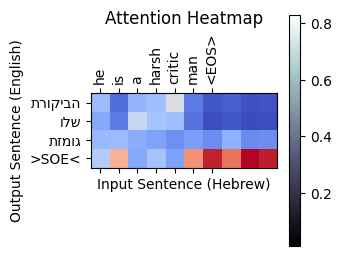

Input: היא מפורסמת
Target: she is widely known
Output: she is widely known <EOS>
Attention Shape: torch.Size([1, 10, 3])


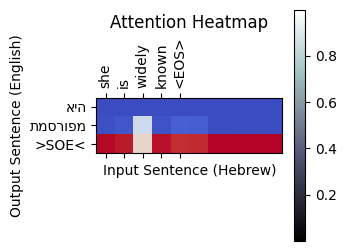

Input: היא ילדה ותו לא
Target: she is a mere child
Output: she is a mere child <EOS>
Attention Shape: torch.Size([1, 10, 5])


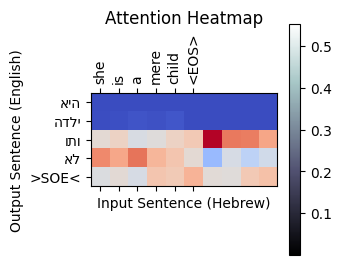

Input: הם מרוצים מהחוזה
Target: they are satisfied with the contract
Output: they are satisfied with the contract number me for payment
Attention Shape: torch.Size([1, 10, 4])


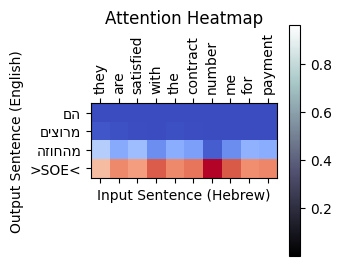

Input: היא לא שם
Target: she isnt there
Output: she isnt there <EOS>
Attention Shape: torch.Size([1, 10, 4])


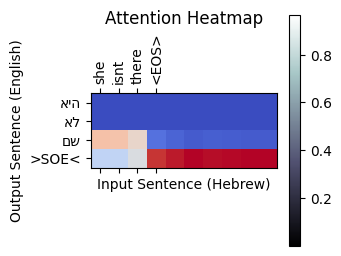

[('הביקורת שלו גומזת',
  'he is a harsh critic',
  'he is a harsh critic man <EOS>'),
 ('היא מפורסמת', 'she is widely known', 'she is widely known <EOS>'),
 ('היא ילדה ותו לא', 'she is a mere child', 'she is a mere child <EOS>'),
 ('הם מרוצים מהחוזה',
  'they are satisfied with the contract',
  'they are satisfied with the contract number me for payment'),
 ('היא לא שם', 'she isnt there', 'she isnt there <EOS>')]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words  # Use predicted output, not the target

    # Verify and adjust lengths to match attention matrix
    expected_input_len = attentions.shape[1]
    expected_output_len = attentions.shape[0]

    # if len(input_tokens) != expected_input_len:
    #     print(f"Adjusting input tokens from {len(input_tokens)} to {expected_input_len}")
    #     input_tokens = input_tokens[:expected_input_len]

    # if len(output_tokens) != expected_output_len:
    #     print(f"Adjusting output tokens from {len(output_tokens)} to {expected_output_len}")
    #     output_tokens = output_tokens[:expected_output_len]

    # if attentions.shape != (len(output_tokens), len(input_tokens)):
    #     print(f"Error: Final mismatch in attention shape {attentions.shape} vs. input ({len(input_tokens)}) & output ({len(output_tokens)}) tokens")
    #     return  # Avoid crashing

    fig, ax = plt.subplots(figsize=(3, 3))
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Transpose the attention matrix for correct orientation
    cax = ax.matshow(attentions.T, cmap='coolwarm')

    # Set tick positions correctly
    ax.set_xticks(range(len(output_tokens)))
    ax.set_xticklabels(output_tokens, rotation=90, ha='center')  # English output on x-axis

    ax.set_yticks(range(len(input_tokens)))
    ax.set_yticklabels([word[::-1] for word in input_tokens])  # Hebrew input (right-to-left)

    # Ensure only 1 set of ticks is applied
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(output_tokens))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(input_tokens))))

    plt.xlabel('Output Sentence (English)')
    plt.ylabel('Input Sentence (Hebrew)')

    # # Set up axes correctly
    # ax.set_xticks(range(len(input_tokens)))
    # ax.set_xticklabels(input_tokens, rotation=90)

    # ax.set_yticks(range(len(output_tokens)))
    # ax.set_yticklabels(output_tokens)

    # # Improve layout
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # input_ticks= [word[::-1] for word in input_tokens ]
    # ax.set_xticklabels(input_ticks, rotation=90, ) #ha='left')

    # # Set color map to 'coolwarm' for better contrast
    # cax = ax.matshow(attentions, cmap='coolwarm')
    plt.xlabel('Input Sentence (Hebrew)')
    plt.ylabel('Output Sentence (English)')
    plt.title('Attention Heatmap')


    display(fig)  # Explicitly display in Google Colab
    # plt.show()
    plt.close(fig)  # Prevent duplicate figures


def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(input_sentence, output_words, attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences


### Running

In [ ]:


evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=10, return_sentences=False)

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)


In [ ]:
evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


Input: אני הולך
Target: i am going
Output: i am all <EOS>
Attention Shape: torch.Size([1, 10, 3])


[('אני הולך', 'i am going', 'i am all <EOS>')]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch


evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


Input: אין לנו זמן רב תום
Target: we are short of time tom
Output: we are short of time tom <EOS>
Attention Shape: torch.Size([1, 10, 6])


# Applying changes:


Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['she cant have written it herself', 'לא ייתכן שהיא כתבה זאת בעצמה'], ['i was deeply impressed by roman architecture', 'התרשמתי עמוקות מהארכיטקטורה הרומאית'], ['it is impossible to put the plan into practice', 'אי אפשר לממש את התכנית'], ['listen carefully to what im going to tell you', 'הקשב היטב למה שאגיד לך'], ['i dont care what she eats', 'לא איכפת לי מה היא אוכלת'], ['he was born dumb', 'הוא נולד אילם'], ['tom is laughing at mary', 'תום צוחק על מרי'], ['whats your favorite way to cook beans', 'מה הדרך בה אתה מעדיף לבשל שעועית'], ['i keep a diary in english', 'אני מנהל יומן באנגלית'], ['to the best of my knowledge no', 'למיטב ידיעתי לא']]
sample of pairs - reversed! [['תן לי 

<Figure size 640x480 with 0 Axes>

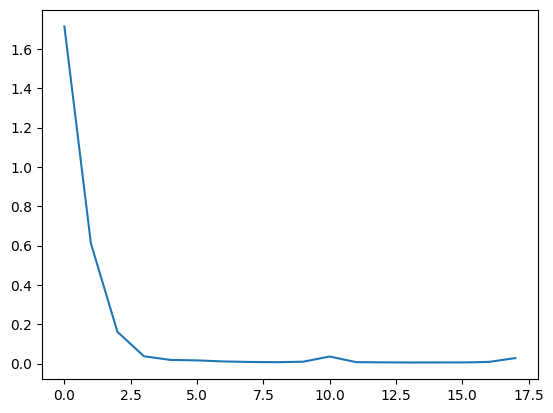

In [ ]:
hidden_size = 248
batch_size = 16

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 90, print_every=5, plot_every=5)